# ML Lab

This notebook is developed for the "Optimisation & Machine Learning" workshop, organised by UK Metamaterials Network (UKMMN); for educational purposes only.
- Authors: Amber Wang, Erin Yu & Ajit Panesar (IDEA Lab, Imperial College London)
- Version: v1 (20/01/2026)
- Comments and corrections to a.panesar@imperial.ac.uk, a.wang20@imperial.ac.uk

--------------

# (c). MLP hyperparameter tuning

### Content of ML Lab (c) tutorial

1. Define MLP structures with different hiddlen layers and neuron numbers

2. Train and evaluate different MLP models

3. Compare the performances of models

### What are the hyperparameters in MLP

In our MLP, the **hyperparameters** are the settings we choose before training that control the model’s structure and learning behaviour. Key examples include:
- the **number of hidden layers** and **number of neurons in each hidden layer** (the `HIDDEN` tuple)
- the **dropout rate** (`DROPOUT`) which controls regularisation
- the **batch size** used by the DataLoader
- the **learning rate** and **optimizer** used for gradient descent
- the **number of training epochs**

These values are not learned from the data; instead, we pick and tune them (often by trial and error or systematic search) to achieve good performance and generalisation.

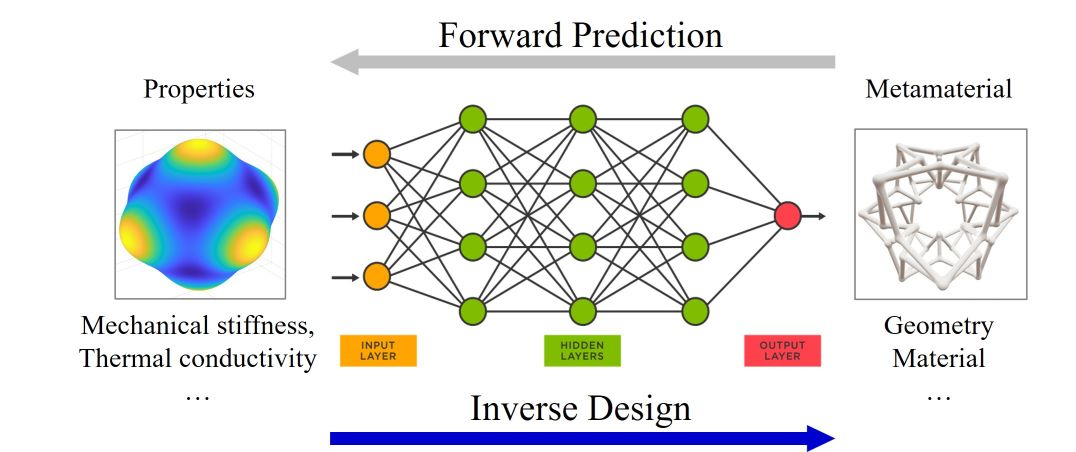

--------------

### Before you get started -  Import library

Run the cell below to import necessarry python libraries for this tutorial.

In [ ]:
# --- Clone repository from Git
!git clone https://github.com/amberwang56977/MLLab.git
%cd MLLab

# --- Standard library
import time
import math
import random

# --- Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PyTorch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# --- Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load predefined functions
from homogenise2D import generate_BCC_unitcell
from MLPpackage import *
from MLPextention import *

Cloning into 'MLLab'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 1.07 MiB | 17.11 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/MLLab


-----------

<h3><font color="lightblue">Preprocess the dataset and define basic MLP model</font></h3>

In [ ]:
# --- Load the dataset as numpy array
data  = np.load("dataset_2D_BCC_500.npz")
prop  = data["prop"]    # input features
param = data["param"]   # target outputs

# --- Determine dimensions
N, in_dim  = prop.shape
_, out_dim = param.shape

In [ ]:
# --- Split dataset
prop_train, prop_val, prop_test, param_train, param_val, param_test = split_prop_param(
    prop, param, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, print_summary=False)

In [ ]:
# --- Scale dataset
prop_train, prop_val, prop_test, param_train, param_val, param_test, in_scaler, out_scaler = scale_datasets(
    prop_train, prop_val, prop_test, param_train, param_val, param_test,
    scale_inputs=True, scale_outputs=True, feature_range=(-1, 1), print_summary=False)

In [ ]:
# --- Convert to Torch tensors
X_train, Y_train, X_val, Y_val, X_test, Y_test = map(
    lambda a: torch.from_numpy(a).float(),
    (prop_train, param_train, prop_val, param_val, prop_test, param_test))

In [ ]:
# --- Data loader
BATCH_SIZE = 256 # number of samples per mini-batch

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   Y_val),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test,  Y_test),  batch_size=BATCH_SIZE, shuffle=False)

### 1. Define different MLP models

This block defines several different MLP model architectures that we will compare during experiments:

- **Small(8)** – a small network with a single hidden layer (compact, fast, but limited capacity).  
- **Medium(8,4)** – a slightly larger network with two hidden layers, giving it more representational power.  
- **Deep(16,8,4)** – a deeper network with three hidden layers, able to learn more complex patterns but also more prone to overfitting.  
- **Wide(16,16)** – a wide network with two large hidden layers, focusing on width rather than depth.  
- **Shallow(4)** – a shallow network with just one moderately sized hidden layer, a balance between simplicity and capacity.

Later, we can loop over these setups to see how model size and depth affect performance.


In [ ]:
# Architectures to compare: feel free to add/remove tuples
ARCHS = {
    "Small(8)":        (8,),
    "Medium(8,4)":     (8, 4),
    "Deep(16,8,4)":    (16, 8, 4),
    "Wide(16,16)":     (16, 16),
    "Shallow(4)":      (4,),
}

# Shared training settings
LR = 1e-3      # Learning rate: step size used by the optimiser when updating weights
WD = 1e-5      # Weight decay: L2 regularisation strength to reduce overfitting
EPOCHS = 300   # Maximum number of full passes through the training dataset
PATIENCE = 20  # Early stopping patience: stop if validation loss doesn't improve for N epochs

### 2. Train and evaluate the MLP models

Use a helper **`run_experiment`** to build, train, time, and evaluate one model. It builds an MLP with the given hidden-layer sizes, trains it with early stopping, tracks the time to run, evaluates performance on the test set, and returns the trained model along with key metrics and learning curves.

We now loop over all candidate architectures, run **`run_experiment`** for each one, and store the results in a dictionary. Afterwards, we print a summary table sorted by best validation MSE so we can quickly compare how each model performs in terms of validation error, test error, number of parameters, and training time.

In [ ]:
results = {}
for name, hidden in ARCHS.items():
    print(f"==> Running: {name} with hidden={hidden}")
    results[name] = run_experiment(hidden=hidden, in_dim=in_dim, out_dim=out_dim, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                                   lr=LR, wd=WD, epochs=EPOCHS, patience=PATIENCE)

for n in sorted(results, key=lambda k: results[k]["best_val_mse"]):
    r = results[n]
    test_err = r.get("overall_test_mse", r.get("overall_test_rmse", float('nan')))
    print(f"{n:20s} | val MSE={r['best_val_mse']:.6f} | test={test_err:.6f} | params={r['params']:,} | time={r['time_sec']:.1f}s")

==> Running: Small(8) with hidden=(8,)
==> Running: Medium(8,4) with hidden=(8, 4)
==> Running: Deep(16,8,4) with hidden=(16, 8, 4)
==> Running: Wide(16,16) with hidden=(16, 16)
==> Running: Shallow(4) with hidden=(4,)
Wide(16,16)          | val MSE=0.001334 | test=0.001154 | params=468 | time=2.3s
Small(8)             | val MSE=0.006968 | test=0.008421 | params=100 | time=2.9s
Medium(8,4)          | val MSE=0.014138 | test=0.011965 | params=120 | time=2.4s
Deep(16,8,4)         | val MSE=0.052565 | test=0.063648 | params=320 | time=2.2s
Shallow(4)           | val MSE=0.053995 | test=0.051187 | params=52 | time=1.9s


### 3. Compare the preformances of MLP models

Compare models: this block runs all candidate architectures and summarises them side by side, letting you compare validation loss, test RMSE, number of parameters, and training time for each model.

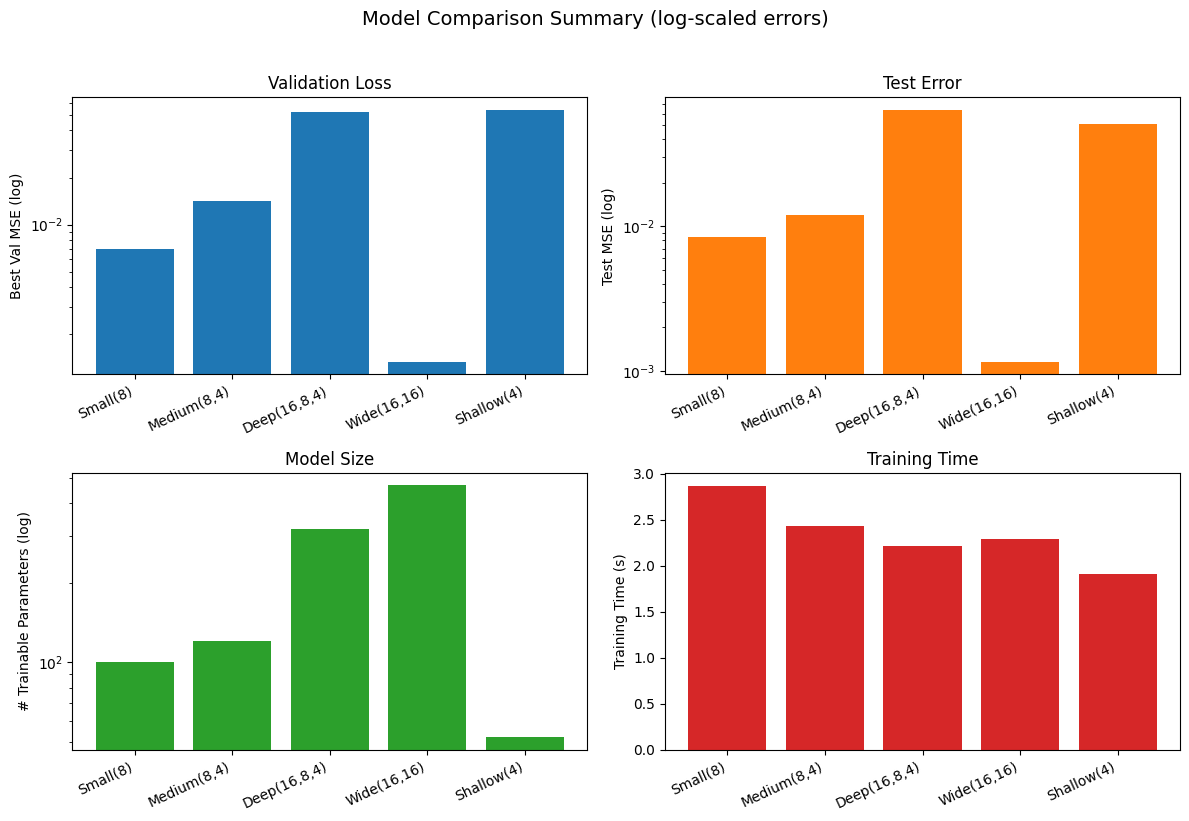

In [ ]:
plot_model_comparison(results, test_key="overall_test_mse")   # or "overall_test_rmse"

Overlay validation curves (log scale)

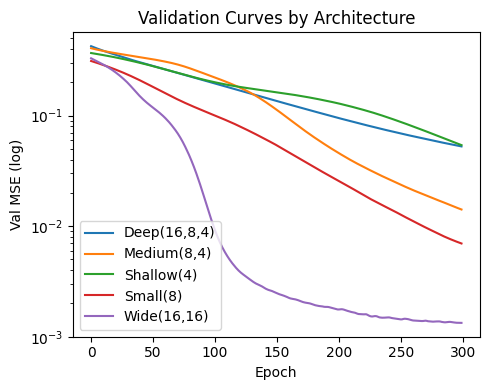

In [ ]:
plot_val_curves(results, log=True, figsize=(5,4), names=sorted(results))

In [ ]:
names = sorted(results, key=lambda k: results[k]["best_val_mse"])
df = pd.DataFrame([{"Architecture": n, "Hidden": (r:=results[n])["hidden"], "Param Number": r["params"],
                    "Best Val MSE": r["best_val_mse"], "Test RMSE": r["overall_test_rmse"],
                    "Test MAE": r["overall_test_mae"], "Time (s)": r["time_sec"]} for n in names])
df

,Architecture,Hidden,Param Number,Best Val MSE,Test RMSE,Test MAE,Time (s)
0,"Wide(16,16)","(16, 16)",468,0.001334,0.033959,0.029141,2.288536
1,Small(8),"(8,)",100,0.006968,0.089833,0.071182,2.868420
2,"Medium(8,4)","(8, 4)",120,0.014138,0.101927,0.074361,2.435705
3,"Deep(16,8,4)","(16, 8, 4)",320,0.052565,0.229955,0.171070,2.219855
4,Shallow(4),"(4,)",52,0.053995,0.224778,0.164117,1.910370
